In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.models.hyperparameter_tuning import *
import os

In [2]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


In [3]:
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

In [4]:
# Add 3 lags
df['inflow_lag1'] = df['inflow'].shift(1)
df['inflow_lag2'] = df['inflow'].shift(2)
df['inflow_lag3'] = df['inflow'].shift(3)
# Trim NaN
df = df['1944-01-04':'2022-12-31']

In [5]:
# Train / val / test split
df_train, df_val, df_test = train_val_test(data=df, train_frac=0.6, val_frac=0.2, test_frac=0.2)

In [6]:
df_train.isna().sum().sum(), df_val.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 139)

In [7]:
# Fill NA with training mean
df_test = df_test.fillna(df_train.mean())

In [10]:
# Standardize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
original_df_cols = df_train.columns
df_train = scaler.fit_transform(df_train)
df_val = scaler.transform(df_val)
df_test = scaler.transform(df_test)

In [13]:
original_df_cols

Index(['inflow', 'outflow', 'storage', 'doy', 'inflow_lag1', 'inflow_lag2',
       'inflow_lag3'],
      dtype='object')

In [18]:
X_train, X_val, X_test = df_train[:, 3:7], df_val[:, 3:7], df_test[:, 3:7]
y_train, y_val, y_test = df_train[:, 1], df_val[:, 1], df_test[:, 1]

In [48]:
# Train a model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=7)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=7)

In [49]:
model.score(X_train, y_train), model.score(X_val, y_val), model.score(X_test, y_test)

(0.69559014117471, 0.5422167233589903, 0.30181792545819497)

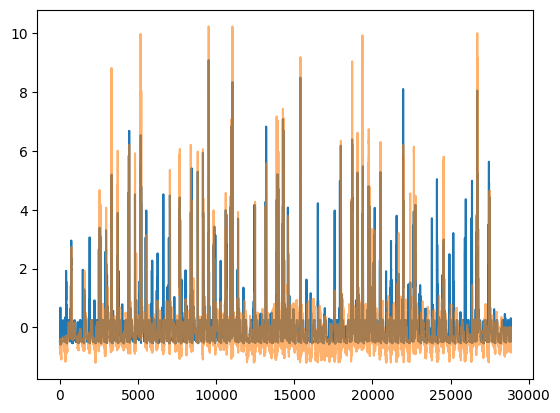

In [50]:
plt.plot(np.concatenate([model.predict(X_train), model.predict(X_val), model.predict(X_test)]))
plt.plot(np.concatenate([y_train, y_val, y_test]), alpha=0.6)
plt.show()